In [ ]:
import os

os.chdir("/root/research/sources/multi-targeted-uap")

import json
import re

import torch

import wandb

# Online
api = wandb.Api()
run_path = "lichangyue/label_num_DNN_test/0ex4qqxf"
run = api.run(run_path)
config = json.loads(run.json_config)
file = run.file("perturbation.pth").download(root="./save", replace=False, exist_ok=True)
results = torch.load(file.name)
config = {key: value["value"] for key, value in config.items() if key != "_wandb"}


In [ ]:
from config import Config

cfg = Config()
cfg.__dict__.update(config)
cfg.sample_id = torch.tensor([list(map(int, re.findall(r"\d+", x))) for x in cfg.sample_id[1:-2].split(r"]")])
cfg.sample_id = torch.tensor(cfg.sample_id)


/tmp/ipykernel_161942/3875625448.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cfg.sample_id = torch.tensor(cfg.sample_id)


In [ ]:
from attacks import get_attacker
from demo import attack_dataloader
from models import get_model

model = get_model(cfg.model_name)
embeddings = []
hook_handlers = []


# get the latent embedding of the image
def hook_fn(module, input, output):
    embeddings.append(output.detach().cpu())


hook_handlers.append(list(model.model.modules())[-2].register_forward_hook(hook_fn))

dataloader = attack_dataloader(cfg.dataset_name, cfg.sample_id, cfg.targets, shuffle=False, batch_size=1)
attacker = get_attacker(cfg, model)


In [4]:
attacker.pert = results["perturbation"].unsqueeze(0)
print(attacker.pert.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
cosine_similarity = torch.nn.CosineSimilarity()
original_labels = []
adversarial_labels = []
original_preds = []
target_labels = []


@torch.no_grad()
def item_pred(item: dict):
    # embeddings.clear()
    # print("original label", item['label'][-1])
    # print("target", item['target'][-1])
    original_labels.append(item["labels"][-1])
    target_labels.append(item["targets"][-1])
    image = item["images"].cuda()
    logits = model.model(image)
    # print("original predict label", logits.argmax(-1).item())
    original_preds.append(logits.argmax(-1).item())
    inputs, target = attacker.get_adv_inputs(**item, generation=True)
    image, target = inputs["pixel_values"].cuda(), target.cuda()
    logits = model.model(image)
    # print("Adversarial pred", logits.argmax(-1).item())
    adversarial_labels.append(logits.argmax(-1).item())

In [ ]:
embeddings.clear()
from tqdm import tqdm

for item in tqdm(dataloader):
    item_pred(item)


100%|██████████| 90/90 [00:15<00:00,  5.73it/s]


In [ ]:
def get_distance(emb):
    distance = torch.nn.functional.cosine_similarity(emb.unsqueeze(1), emb.unsqueeze(0), dim=-1)
    return distance.mean()


image_embeddings = embeddings[::2]
adversarial_embeddings = embeddings[1::2]
image_embeddings = torch.cat(image_embeddings, dim=0)
adversarial_embeddings = torch.cat(adversarial_embeddings, dim=0)
all_embeddings = torch.cat([image_embeddings, adversarial_embeddings], dim=0)
print(get_distance(image_embeddings))
print(get_distance(adversarial_embeddings))
print(get_distance(all_embeddings))

tensor(0.4933)
tensor(0.8186)


# calc emb cos for each targets

In [ ]:
step = image_embeddings.shape[0] / len(cfg.targets)
for i in range(len(cfg.targets) * 2):
    print(get_distance(all_embeddings[int(i * step) : int((i + 1) * step), :]))

tensor(0.6222)
tensor(0.6780)
tensor(0.7435)
tensor(0.8546)
tensor(0.8920)
tensor(0.8856)


In [ ]:
step = adversarial_embeddings.shape[0] / len(cfg.targets)
for i in range(len(cfg.targets)):
    print(get_distance(adversarial_embeddings[int(i * step) : int((i + 1) * step), :]))

tensor(0.8546)
tensor(0.8920)
tensor(0.8856)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def plot_tsne(emb):
    tsne = TSNE(n_components=2, random_state=0)
    _emb = emb.cpu().numpy()
    return tsne.fit_transform(_emb)

In [38]:
all_embeddings = torch.cat([image_embeddings, adversarial_embeddings], dim=0)


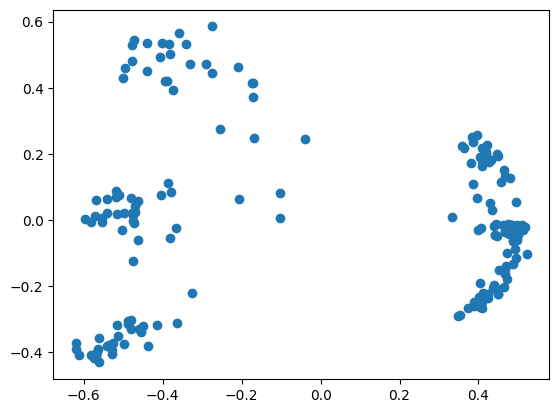

In [ ]:
def pca(embeddings):
    normalized_embeddings = embeddings / torch.norm(embeddings, p=2, dim=1, keepdim=True)
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    return pca.fit_transform(normalized_embeddings)


pca_embeddings = pca(all_embeddings)
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1])

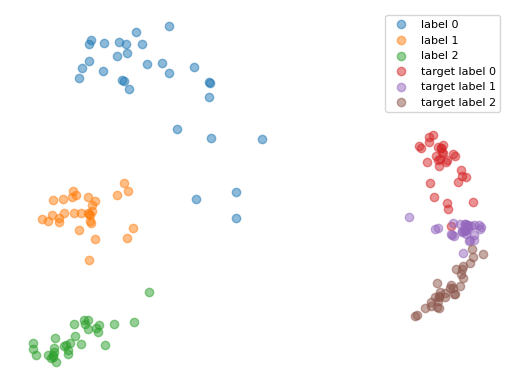

In [ ]:
step = 30
plt.scatter(pca_embeddings[:step, 0], pca_embeddings[:step, 1], label="label 0", alpha=0.5)
plt.scatter(pca_embeddings[step : 2 * step, 0], pca_embeddings[step : 2 * step, 1], label="label 1", alpha=0.5)
plt.scatter(pca_embeddings[2 * step : 3 * step, 0], pca_embeddings[2 * step : 3 * step, 1], label="label 2", alpha=0.5)
plt.scatter(
    pca_embeddings[3 * step : 4 * step, 0], pca_embeddings[3 * step : 4 * step, 1], label="target label 0", alpha=0.5
)
plt.scatter(
    pca_embeddings[4 * step : 5 * step, 0], pca_embeddings[4 * step : 5 * step, 1], label="target label 1", alpha=0.5
)
plt.scatter(
    pca_embeddings[5 * step : 6 * step, 0], pca_embeddings[5 * step : 6 * step, 1], label="target label 2", alpha=0.5
)
plt.legend(loc="upper right", fontsize=8)
plt.axis("off")
plt.show()

30.0